## **MNIST RGB Inpainting**

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
from torchvision.datasets import MNIST

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'. 

**Do not change the cell**.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

#if device.type == 'cuda':
  #  print('GPU Name:', torch.cuda.get_device_name(0))
  #  print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cpu


### **Setting Library Seeds for Reproducibility**

the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. 

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

### **Preparing the Dataset**

The MNIST RGB dataset is downloadable from [this link](https://drive.google.com/file/d/1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [5]:
# import gdown # Library to download files from Google Drive
# !gdown 1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ # Google Drive ID of the zip file to be downloaded
# !unzip -oq mnist_dataset_rgb # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

### **Implementing a Custom Dataset [20 Points]**

In this part, we implement a custom PyTorch dataset class that reads MNIST RGB images from a dataset split folder. There are two split folders called training and test in the dataset. The model class takes the root directory of a split in the \_\_init\_\_ function and reads the images accordingly. Before returning the requested images, we apply the following steps:

* bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [5]:
class MnistDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize((32,32), interpolation = Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,))
        ])
        
        self.data = []
        counts = len(os.listdir(self.root_dir))
        for number in range (counts):
             for filename in os.listdir(os.path.join(self.root_dir, str(number))):
                img = Image.open(os.path.join(self.root_dir + "/" + str(number), filename))
                img = self.transform(img)
                self.data.append(img)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, data_id):
        return self.data[data_id]

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [6]:
 batch_size= 64

#train_dataset = MNIST(root='./data/', train=True, download=True)
#train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, pin_memory=True, num_workers=0)

train_dataset = MnistDataset('C:/Users/Admin/Desktop/Project Unsup/Mnist/mnist_dataset_rgb/training')
train_dataloader = DataLoader(train_dataset, train=True, batch_size = batch_size, shuffle = True, num_workers=4)

#test_dataset = MNIST(root='./data/', train=False, download=False)
#test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = False, pin_memory=True, num_workers=0)

test_dataset = MnistDataset('C:/Users/Admin/Desktop/Project Unsup/Mnist/mnist_dataset_rgb/test')
test_dataloader = DataLoader(test_dataset, train=False, batch_size = batch_size, shuffle = False, num_workers=4)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of MNIST RGB images properly.

In [ ]:
images = next(iter(train_dataloader))
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Autoencoder Networks**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two subnetworks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part of the homework, you are requested to implement two different autoencoder networks, which are fully connected and convolutional autoencoders.

#### **Fully Connected Autoencoder**

Fully connected networks consist of multiple [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). The figure of the architecture is provided below, where the number of nodes is kept small for simplification. 

![Fully Connected Autoencoder Architecture](https://drive.google.com/uc?export=view&id=1JeDQtjvWVoT5dZhVxesQp_XiqAnUvi1i)

In this part, we implement the layers and the forward function of the model. we flatten the input image before feeding it to the network and unflatten it when the final activations are obtained. The (input_size, output_size) pairs of the layers should be defined as follows:

**Encoder:**
- (3\*32\*32, 256)
- (256, 64)
- (64, 16)

**Decoder:**
- (16, 64)
- (64, 256)
- (256, 3\*32\*32)

In each layer, [1D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) should be applied and the resulting values  passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs bounded so. Therefore, we  are using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In [7]:
class MnistAutoencoderFC(nn.Module):
    def __init__(self):
        super(MnistAutoencoderFC,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,64),
            nn.BatchNorm1d(64),    
            nn.LeakyReLU(0.2),
            nn.Linear(64,16),
            nn.BatchNorm1d(16),    
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 3*32*32),
            nn.Tanh()
        )
        
       

    def forward(self, x):
        # x = x.view(x.size(0),-1)
        x = nn.Flatten()(x)
        x = self.encoder(x)
        x = self.decoder(x)
        # x = x.view(x.size(0), 3, 32, 32)
        x = nn.Unflatten(1,(3,32,32))(x)
        return x

#### **Convolutional Autoencoder**

In this part, we implement an autoencoder model using convolutional layers. The architecture of a convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=18Ztf-zhMFC_IXDTnvGCUeGgZx-7duu0o)

 The (in_channel, out_channel) pairs of the layers are defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to change the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)is applied and the resulting values is passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs is bounded so. Therefore, we are using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers. 

In the encoder part of the network, use max pooling in each layer for decreasing the resolution. The stride size is set to one in these layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back. 

In [8]:
class MnistAutoencoderConv(nn.Module):
    def __init__(self):
        super(MnistAutoencoderConv, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 5, padding = 1, stride = 1, padding_mode='replicate'),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,stride = 2),
            
            nn.Conv2d(16, 32,kernel_size = 4, padding =1, stride = 1, padding_mode='replicate'),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride = 2),
            
            nn.Conv2d(32, 64,kernel_size = 3,  padding = 1, stride = 1, padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride = 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32,kernel_size = 5, stride = 2,  padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16,kernel_size = 5,  stride = 2,  padding = 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3,kernel_size = 6, stride = 2,  padding = 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Implementing the Training Loop**

this function will be called to train both the fully connected and the convolutional autoencoders. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch.

To be able to learn inpainting, we  mask the input images as follows:

![MNIST Masking](https://drive.google.com/uc?export=view&id=1gIELbRSE188PQHv_uGktPX_2cvAtMbN-)

Simply, we set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, we use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [9]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    
    model.train()
    losses = []
    for epoch in range (num_epochs):
        running_loss = 0.0
        for data in train_dataloader:
            #print(data.shape)
            img = data
            img1 = img.clone()
            img1[:, :, :, 16:] = -1.0
            targets = data

            
            optimizer.zero_grad()
            outputs = model(img1.to('cuda'))

            loss = loss_func(outputs, targets.to('cuda'))
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        epoch_loss = running_loss / len(train_dataloader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return losses

### **Implementing the Evaluation Function**

An evaluation function that returns the mean MSE calculated over the test dataset samples.

In [10]:
def evaluate_model(model, test_dataloader):
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            img = data
            img1 = img.clone()
            img1[:, :, :, 16:] = -1.0
            outputs = model(img1.to('cuda'))
            loss = nn.MSELoss()
            loss.to('cuda')
            mse = loss(outputs, img.to('cuda'))
            #mse = torch.mean((outputs - img.to('cuda')) ** 2)
            total_mse += mse.item()
            
    mean_mse = total_mse / len(test_dataloader)
    return mean_mse

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. 

In [11]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the FC Model**

we define the loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, we call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, we call evaluate_model function that we implemented and print the accuracy the model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.


Epoch [1/50], Loss: 0.1468
Epoch [2/50], Loss: 0.0800
Epoch [3/50], Loss: 0.0722
Epoch [4/50], Loss: 0.0678
Epoch [5/50], Loss: 0.0650
Epoch [6/50], Loss: 0.0629
Epoch [7/50], Loss: 0.0612
Epoch [8/50], Loss: 0.0598
Epoch [9/50], Loss: 0.0588
Epoch [10/50], Loss: 0.0578
Epoch [11/50], Loss: 0.0570
Epoch [12/50], Loss: 0.0563
Epoch [13/50], Loss: 0.0557
Epoch [14/50], Loss: 0.0551
Epoch [15/50], Loss: 0.0546
Epoch [16/50], Loss: 0.0541
Epoch [17/50], Loss: 0.0537
Epoch [18/50], Loss: 0.0533
Epoch [19/50], Loss: 0.0529
Epoch [20/50], Loss: 0.0526
Epoch [21/50], Loss: 0.0523
Epoch [22/50], Loss: 0.0520
Epoch [23/50], Loss: 0.0518
Epoch [24/50], Loss: 0.0514
Epoch [25/50], Loss: 0.0511
Epoch [26/50], Loss: 0.0510
Epoch [27/50], Loss: 0.0508
Epoch [28/50], Loss: 0.0505
Epoch [29/50], Loss: 0.0502
Epoch [30/50], Loss: 0.0501
Epoch [31/50], Loss: 0.0499
Epoch [32/50], Loss: 0.0497
Epoch [33/50], Loss: 0.0495
Epoch [34/50], Loss: 0.0494
Epoch [35/50], Loss: 0.0493
Epoch [36/50], Loss: 0.0491
E

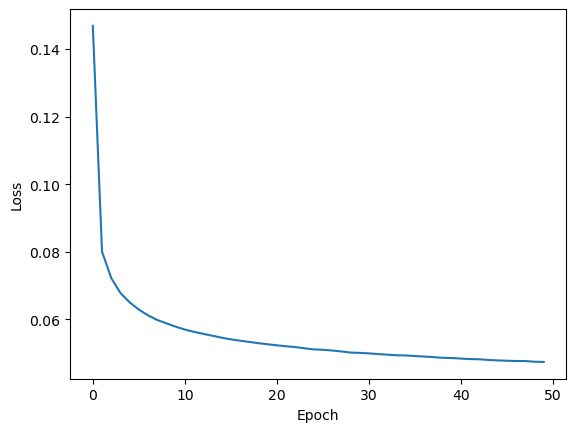

Mean MSE: 0.0469


In [14]:
seed_everything(464)
lr = 2e-4
model_fc = MnistAutoencoderFC() ## Uncomment when the model is implemented
model_fc.cuda()
criterion = torch.nn.MSELoss()
criterion.cuda()
optimizer = optim.Adam(model_fc.parameters(), lr = lr)
num_epochs = 50

losses = train_model(model_fc, train_dataloader, optimizer, criterion, num_epochs)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


mean_mse = evaluate_model(model_fc, test_dataloader)
print(f'Mean MSE: {mean_mse:.4f}')


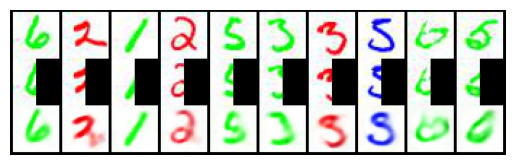

In [15]:
visualize_inpainting(model_fc, test_dataset)

### **Training and Evaluating the Convolutional Model**

Apply the same steps given in the FC Autoencoder part.

Epoch [1/50], Loss: 0.1574
Epoch [2/50], Loss: 0.0630
Epoch [3/50], Loss: 0.0554
Epoch [4/50], Loss: 0.0518
Epoch [5/50], Loss: 0.0496
Epoch [6/50], Loss: 0.0479
Epoch [7/50], Loss: 0.0466
Epoch [8/50], Loss: 0.0455
Epoch [9/50], Loss: 0.0448
Epoch [10/50], Loss: 0.0439
Epoch [11/50], Loss: 0.0434
Epoch [12/50], Loss: 0.0429
Epoch [13/50], Loss: 0.0424
Epoch [14/50], Loss: 0.0419
Epoch [15/50], Loss: 0.0415
Epoch [16/50], Loss: 0.0412
Epoch [17/50], Loss: 0.0409
Epoch [18/50], Loss: 0.0406
Epoch [19/50], Loss: 0.0403
Epoch [20/50], Loss: 0.0400
Epoch [21/50], Loss: 0.0398
Epoch [22/50], Loss: 0.0396
Epoch [23/50], Loss: 0.0393
Epoch [24/50], Loss: 0.0392
Epoch [25/50], Loss: 0.0390
Epoch [26/50], Loss: 0.0387
Epoch [27/50], Loss: 0.0386
Epoch [28/50], Loss: 0.0385
Epoch [29/50], Loss: 0.0383
Epoch [30/50], Loss: 0.0382
Epoch [31/50], Loss: 0.0380
Epoch [32/50], Loss: 0.0379
Epoch [33/50], Loss: 0.0378
Epoch [34/50], Loss: 0.0376
Epoch [35/50], Loss: 0.0375
Epoch [36/50], Loss: 0.0374
E

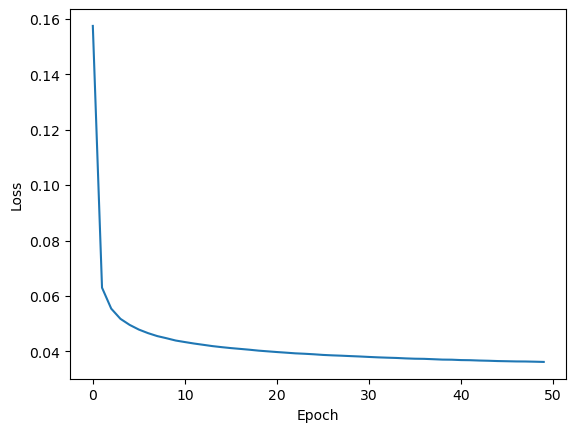

Mean MSE: 0.0397


In [16]:
seed_everything(464)
model_conv = MnistAutoencoderConv()
lr = 2e-4
model_conv.cuda()
criterion = torch.nn.MSELoss()
criterion.cuda()
optimizer = optim.Adam(model_conv.parameters(), lr = lr)
num_epochs = 50
losses = train_model(model_conv, train_dataloader, optimizer, criterion, num_epochs)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

mean_mse = evaluate_model(model_conv, test_dataloader)
print(f'Mean MSE: {mean_mse:.4f}')

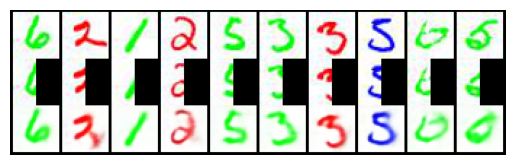

In [17]:
visualize_inpainting(model_conv, test_dataset)

### **Discussion**

As it is seen, the loss function for the FC autoencoder decreases in each epoch, and finally, its value for the last epoch is 0.0473. The MSE loss in evaluation on the test dataset for this model is 0.0469, while the loss function for the convolutional autoencoder decreases to 0.0362 in the last epoch, and the MSE loss in evaluation on the test dataset of the convolutional autoencoder model is 0.0397. A lower MSE loss indicates better reconstruction accuracy, so the convolutional autoencoder performed better in terms of minimizing the pixel-wise differences between the input and output images. In addition, the FC autoencoder uses fully connected layers, while the convolutional autoencoder uses convolutional layers and transposed convolutional layers. Convolutional layers are specifically designed to capture spatial information, making them more suitable for image data. This could explain why the convolutional autoencoder outperformed the FC autoencoder in terms of image reconstruction quality. Furthermore, the visualization of the outputs shows that the outputs from the convolutional autoencoder are less blurry compared to the FC autoencoder. This indicates that the convolutional autoencoder is able to capture and preserve more fine-grained details during the reconstruction process. Besides, the FC autoencoder misclassifies one item (blue 5 is recognized as 3). However, there is no miss in the convolutional autoencoder. In conclusion, it seems that the convolutional autoencoder is better suited for image data, as it can effectively leverage the spatial information in the images and produce higher-quality reconstructions, and it learns hierarchical features and captures spatial patterns, resulting in clearer and more accurate reconstructions compared to the FC autoencoder.
